In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
import sys
print (sys.version)

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]


In [5]:
age_groups= range(16)
disease_stages= range(5)
age_at_infection_groups= range(3)
genders = range(2) # 0- Female, 1- Male

In [6]:
female_mortality_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'female mortality rate.csv')
male_mortality_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'male mortality rate.csv')
female_pop_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'Female population by age.csv')
male_pop_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'male population by age.csv')

In [7]:
Mu = np.append([female_mortality_df.values],[male_mortality_df.values], axis=0)
population =np.append([female_pop_df.values],[male_pop_df.values], axis=0)  
# 0-gender, 1-t, 2-age

In [8]:
birth_rate_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'birth_rate.csv')
birth_rate = np.array(birth_rate_df["births"])

In [9]:
blood_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'b.csv')
blood_trans = np.array([blood_df["Female"],blood_df["Male"]])
# 0-gender, 1-age

In [10]:
progress_df = pd.read_csv('C:/Users/User/Dropbox/'
                'Hepatitis C - Noa& Dan/Mathematica/data for model/'
                'p.csv')
progress = np.array([progress_df["0"], progress_df["1"], progress_df["2"]])
# 0-age infection, 1-stage

In [11]:
C0=np.full((len(age_groups), len(disease_stages),
            len(age_at_infection_groups), len(genders)),0)
for g in genders:
    for i in range(0, 4):
        C0[i, 0, 0, g] = 0.025
    for i in range(4, 6):
        for k in range(0, 2):
            C0[i, 0, k, g] = 0.0125
    for i in range(6, len(age_groups)):
        for k in age_at_infection_groups:
            C0[i, 0, k, g] = 0.008333333

C0=np.array(C0).reshape(480)

In [12]:
C0=np.full((len(age_groups), len(disease_stages),
            len(age_at_infection_groups), len(genders)),0)
for g in genders:
    for i in range(0, 4):
        C0[i, 0, 0, g] = 15.1875
    for i in range(4, 6):
        for k in range(0, 2):
            C0[i, 0, k, g] = 7.59375
    for i in range(6, len(age_groups)):
        for k in age_at_infection_groups:
            C0[i, 0, k, g] = 5.0625

C0=np.array(C0).reshape(480)

In [13]:
# The model differential equations.
def deriv(y,t0,alpha,beta,lamda,mu,pop,tt):

    C = np.array(y).reshape(len(age_groups),len(disease_stages),len(age_at_infection_groups),len(genders))
    dCdt=np.full((len(age_groups),len(disease_stages),len(age_at_infection_groups),len(genders)),0)
    
    
    
    infected_donors=0
    maternity=0
    sumpop1=0
    sumpop2=0
    
    for j in disease_stages:
        for k in age_at_infection_groups:
            for g in genders:
                for i1 in range(4,12):
                    #(*donors- ages 20-60*)
                    infected_donors += C[i1, j, k, g]
                    sumpop1+= pop(tt,i1,g)
            for i2 in range(3,10):
                maternity += C[i2, j, k, 0]
                sumpop2+=pop(tt,i2,0)
    
    infected_donors=infected_donors/sumpop1
    maternity=maternity/sumpop2
                
    for g in genders:
        #d1 (*The first age group with F0*)
        dCdt[0,0,0,g]= -C[0,0,0,g]*(progress[0,0] +mu(tt,0,g) + alpha) + lamda(tt)*0.05*maternity +\
            blood_trans[g, 0]*infected_donors*beta* pop(tt,0, g) 
        
        #d3 (*The first age group with F4*)
        dCdt[0, len(disease_stages)-1, 0, g]= -C[0,len(disease_stages)-1, 0, g]*(alpha + mu(tt,0,g)) +\
            C[0, len(disease_stages) - 2, 0, g]*progress[0, len(disease_stages)-2]
    
        for k in age_at_infection_groups:
            #d2 (*The last age group with F4*)
            dCdt[len(age_groups)-1,len(disease_stages)-1,k,g]=C[len(age_groups) - 2, len(disease_stages)-2, k, g]*alpha-\
                mu(tt,len(age_groups)-1,g)*C[len(age_groups)-1, len(disease_stages)-1, k, g] +\
                C[len(age_groups)-1, len(disease_stages) - 2, k, g]*progress[k, len(disease_stages)-2]
            
            #d4 (*The last age group with F0*)
            dCdt[len(age_groups)-1,0,k,g]=C[len(age_groups) - 2, 0, k, g]*alpha -\
                                         mu(tt,len(age_groups)-1, g)*C[len(age_groups)-1, 0, k, g]- \
                                         C[len(age_groups)-1, 0, k, g]*progress[k, 0]
                
        for j in range(1,len(disease_stages) - 2):
            #d9 (*The first age group*)
            dCdt[0, j, 0, g]=  -C[0, j, 0, g]*(mu(tt,0,g)+progress[0,j]+alpha) +\
                C[0, j - 1, 0, g]*progress[0, j-1]
            for k in age_at_infection_groups:
            #d10 (*The last age group*)
                dCdt[len(age_groups)-1, j, k, g]= C[len(age_groups)-2, j, k, g]*alpha -\
                    C[len(age_groups)-1, j, k, g]*(mu(tt,len(age_groups)-1, g)+ progress[k,j]) +\
                    C[len(age_groups)-1, j - 1, k, g]*progress[k, j-1] 
                
        for i in range(1,4):
            #d5 (*F0 population*)
            dCdt[i, 0, 0, g]= -C[i, 0, 0, g]*(progress[0, 0] + mu(tt,i,g) + alpha) + \
                C[i - 1, 0, 0, g]* alpha + blood_trans[g, i]*infected_donors*beta*pop(tt,i,g)
            
            #d8a (*last stage population*)
            dCdt[i, len(disease_stages)-1, 0, g]= C[i - 1, len(disease_stages)-1, 0, g]*alpha -\
                C[i, len(disease_stages)-1, 0, g]*(alpha + mu(tt,i,g)) +\
                C[i, len(disease_stages)-2, 0, g]*progress[0, len(disease_stages)-2]
            
            #d11a
            for j in range(1,len(disease_stages) - 2):
                dCdt[i, j, 0, g]=C[i - 1, j, 0, g]*alpha-C[i, j, 0, g]*(mu(tt,i,g) +alpha)+\
                    C[i, j - 1, 0, g]*progress[0, j-1] -C[i, j, 0, g]*progress[0, j]
            
        for i in range(4,6):
            for k in range(0,2):
                #d6 (*F0 population*)
                dCdt[i, 0, k, g]= -C[i, 0, k, g]*(progress[k, 0] + mu(tt,i,g) + alpha) + \
                    C[i - 1, 0, k, g]* alpha + blood_trans[g, i]*infected_donors*beta*pop(tt,i,g)
            
                #d8b (*last stage population*)
                dCdt[i, len(disease_stages)-1, k, g]= C[i - 1, len(disease_stages)-1, k, g]*alpha -\
                    C[i, len(disease_stages)-1, k, g]*(alpha + mu(tt,i,g)) +\
                    C[i, len(disease_stages)-2, k, g]*progress[k, len(disease_stages)-2]
            
                #d11b
                for j in range(1,len(disease_stages) - 2):
                    dCdt[i, j, k, g]=C[i - 1, j, k, g]*alpha-C[i, j, k, g]*(mu(tt,i,g) +alpha)+\
                        C[i, j - 1, k, g]*progress[k, j-1] -C[i, j, k, g]*progress[k, j]
            
        for i in range(6,len(age_groups)):
            for k in age_at_infection_groups:
                #d7 (*F0 population*)
                dCdt[i, 0, k, g]= -C[i, 0, k, g]*(progress[k, 0] + mu(tt,i,g) + alpha) + \
                    C[i - 1, 0, k, g]* alpha + blood_trans[g, i]*infected_donors*beta*pop(tt,i,g)
            
                #d8c (*last stage population*)
                dCdt[i, len(disease_stages)-1, k, g]= C[i - 1, len(disease_stages)-1, k, g]*alpha -\
                    C[i, len(disease_stages)-1, k, g]*(alpha + mu(tt,i,g)) +\
                    C[i, len(disease_stages)-2, k, g]*progress[k, len(disease_stages)-2]
            
                #d11c
                for j in range(1,len(disease_stages) - 2):
                    dCdt[i, j, k, g]=C[i - 1, j, k, g]*alpha-C[i, j, k, g]*(mu(tt,i,g) +alpha)+\
                        C[i, j - 1, k, g]*progress[k, j-1] -C[i, j, k, g]*progress[k, j]            
            
    dCdt=np.array(dCdt).reshape(480)
    return dCdt


In [15]:
def pop(t0, i, g):
    # 0-gender, 1-t, 2-age
    return population[g, int(t0), i]*1000


def mu(t, i, g):
    # 0-gender, 1-t, 2-age
    return Mu[g, int(t), i]


def lamda(t):
    return float(birth_rate[t])

alpha=0.2
beta=0.15

start_year=0
end_year=62
T = np.arange(0,2)
Time = np.zeros(1)
result=np.zeros(480)
y0=C0


for year in range(start_year, end_year):
    # Solve
    print((year))
    args=(alpha,beta,lamda,mu,pop,year)
    solution = odeint(deriv, y0, T, args)  # Solve Previous Year
    Time = np.hstack((Time, T +(year - start_year)))  # Add times of previous year
    result = np.vstack((result, solution))  # Add solution of last year
    # Transfer to next year
    y0 = solution[-1]



0


C:\Users\User\Anaconda2\envs\py36\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51
52


C:\Users\User\Anaconda2\envs\py36\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


53


54


55


56


57


58


59


60


61


In [77]:
c = y0.T
c = np.array(c).reshape(len(age_groups), len(disease_stages),
                        len(age_at_infection_groups), len(genders))

In [78]:
sum(c)[0]

array([[ 110.15738371,  106.42292425],
       [  51.52906388,   48.20184207],
       [  37.6097811 ,   34.53052233]])

In [17]:
sum(result.T)[1:]

array([ 476.        ,  474.92185456,  474.92185456,  472.33193758,
        472.33193758,  470.50508928,  470.50508928,  465.69680102,
        465.69680102,  464.76670772,  464.76670772,  464.147347  ,
        464.147347  ,  464.14681767,  464.14681767,  464.14618065,
        464.14618065,  464.14555552,  464.14555552,  464.14507364,
        464.14507364,  464.14459776,  464.14459776,  464.14386461,
        464.14386461,  464.14329948,  464.14329948,  464.14273094,
        464.14273094,  464.14218511,  464.14218511,  464.1415201 ,
        464.1415201 ,  464.14102041,  464.14102041,  464.14039814,
        464.14039814,  464.13990535,  464.13990535,  464.13949942,
        464.13949942,  464.13888196,  464.13888196,  464.13818035,
        464.13818035,  464.13760837,  464.13760837,  464.13706004,
        464.13706004,  464.13639085,  464.13639085,  464.13572658,
        464.13572658,  464.11049202,  464.11049202,  464.08536881,
        464.08536881,  464.06023489,  464.06023489,  464.03507

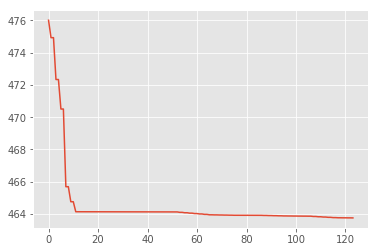

In [16]:
plt.plot(sum(result.T)[1:])
plt.show()

In [ ]:
print ("Yes")

No


In [26]:
df = pd.DataFrame(np.array(c).T, columns=['S', 'I', 'R'])

ValueError: Must pass 2-d input

In [ ]:
def eq_system(y,t,w,sigma,ru,gamma,phai,beta,phi,etha,vac_eff):
    M = y[0] 
    S = y[1:4]
    I = np.array(y[4:13]).reshape(len(stages),len(severity) )
    R = y[13:16]
    V = y[16:19]
    I_d = np.array(y[19:28]).reshape(len(doses),len(severity) )
    
    lamb = calc_force_of_infection(beta,phi,phai,t,I,I_d)
    
    dydt = []
    dydt.append( birth_rate - M*( w[0]*(1-etha[0]) + mu + etha[0]*a[0] ) )        #dM/dt
    
    I_temp = []
    S_temp = []
    R_temp = []
    V_temp = []
    I_d_temp = []
                    
    m = max(stages) #=2

    for k in stages:
        S_temp.append( delta(k)*(w[0]*M*(1-etha[0]) - etha[0]*S[0]*a[0])           #dS/dt
                          + (w[k]*R[k-1] if k > 0 else 0)
                          - (mu+sigma[k]*lamb*(1-etha[0]*delta(k)))*S[k] 
                          + delta(m-k)*w[m+1]*R[m] )

        for l in severity:
            I_temp.append(ru[k,l]*sigma[k]*lamb*S[k]*(1-etha[0]*delta(k))-gamma[k,l]*I[k,l] - I[k,l]*mu)   #dI/dt
        
        R_temp.append(  - R[k]*(w[k+1] + mu) 
                        + ( np.sum([gamma[k,sev]*I[k,sev] for sev in severity]) ) 
                        + delta(k)*( sum([gamma[0,sev]*I_d[d,sev] for d in doses for sev in severity]) )
                     )                                                                #dR/dt
    
    for d in doses:
        V_temp.append( delta(d)*(M+S[0])*etha[0]*a[0]
                      + (V[d-1]*etha[d]*a[d] if d > 0 else 0)   #in : V[d]->V[d+1]
                      - (V[d]*etha[d+1]*a[d+1] if d < 2 else 0) #out: V[d]->V[d+1] 
                      - (sum( [(1-vac_eff[d,l])*sigma[0]*lamb for l in severity]) )*V[d] 
                            *((1-etha[d+1]) if d < 2 else 1) 
                      -mu*V[d] )
            
        for l in severity:
            I_d_temp.append( (1-vac_eff[d,l])*sigma[0]*lamb*V[d]*((1-etha[d+1]) if d < 2 else 1) 
                              - (mu + gamma[0,l])*I_d[d,l] 
                           )
                    
    dydt.extend(S_temp)
    dydt.extend(I_temp)
    dydt.extend(R_temp)
    dydt.extend(V_temp)
    dydt.extend(I_d_temp)
    return dydt